In [349]:
# Standard Libraries
import os
import zipfile
from glob import glob
import random

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
import cv2

# Machine Learning Libraries
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split

**Define Parameters**

In [350]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Seed random
SEED = 42
random.seed(SEED)

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# **Step 1: Load Data**

In [351]:
def extract_data(zip_path, extracted_path):
    '''
    Extracts the ZIP file of the dataset.
    '''
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# TODO: Uncomment to extract data from zip
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [352]:
def load_labels(csv_path, extracted_path):
    '''
    Read labels from CSV, maps images to paths, and create binary disease labels.
    '''

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [353]:
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No Finding,Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,1,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/chestX-ra...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,1,0,/cluster/home/bjorneme/projects/Data/chestX-ra...


**Split Dataset**

In [354]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train dataset size: {len(train_df)}. Number of unique patients: {len(train_patients)}")
print(f"Validation size: {len(val_df)}. Number of unique patients: {len(val_patients)}")
print(f"Test size: {len(test_df)}. Number of unique patients: {len(test_patients)}")

Train dataset size: 78614. Number of unique patients: 21563
Validation size: 11212. Number of unique patients: 3081
Test size: 22294. Number of unique patients: 6161


# **Step 3: Data Augmentations**

**Select Images to Plot**

In [355]:
# Selected from all images
sampled_df = random.sample(df[['Path', 'Finding Labels']].values.tolist(), 9)

# Retrieve the second image (for demonstration puurpose)
sampled_df = sampled_df[1]
img_path = sampled_df[0]
finding_labels = sampled_df[1]

**Images without Augmentations**

In [356]:
transform = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

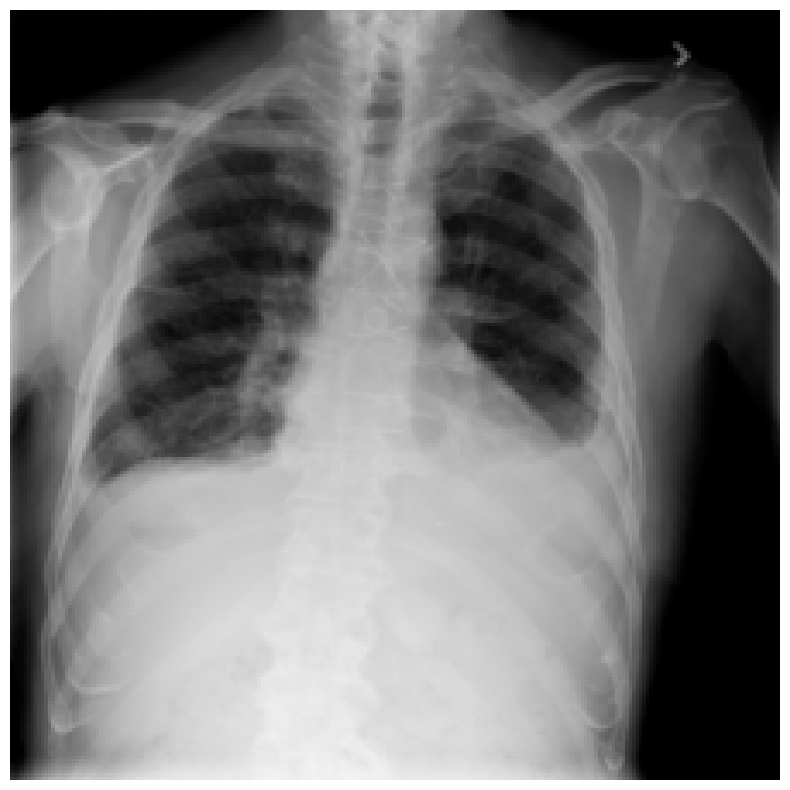

In [357]:
# Transform image
image = plt.imread(img_path)
image = transform(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Random Cropping**

In [358]:
transform_crop = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Randomly resize the image
    transforms.RandomCrop((224,224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

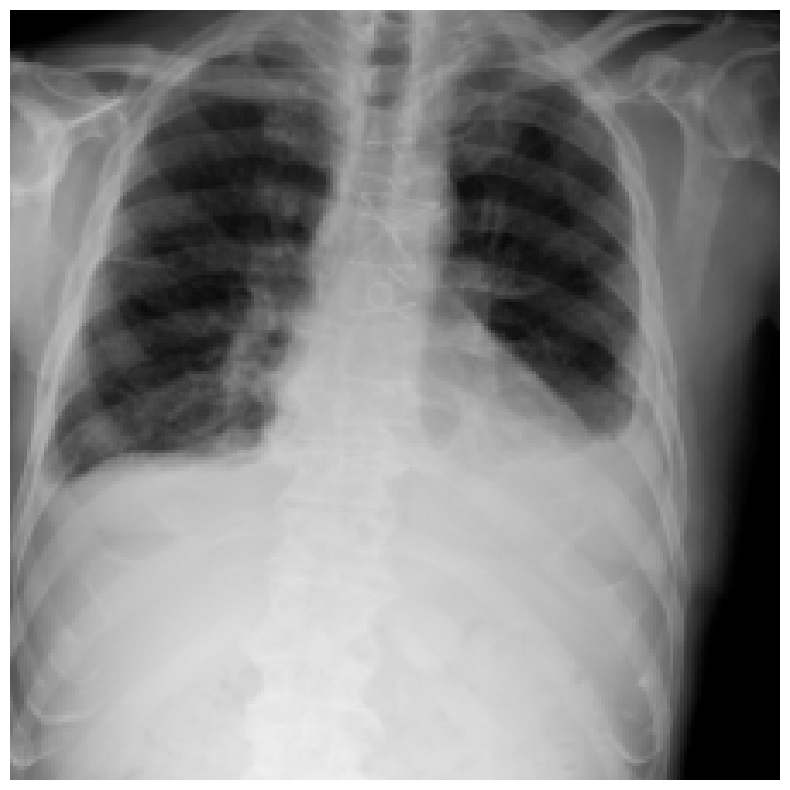

In [359]:
# Transform image
image = plt.imread(img_path)
image = transform_crop(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Random Horizontal Flip**

In [360]:
transform_flip = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(p=1),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

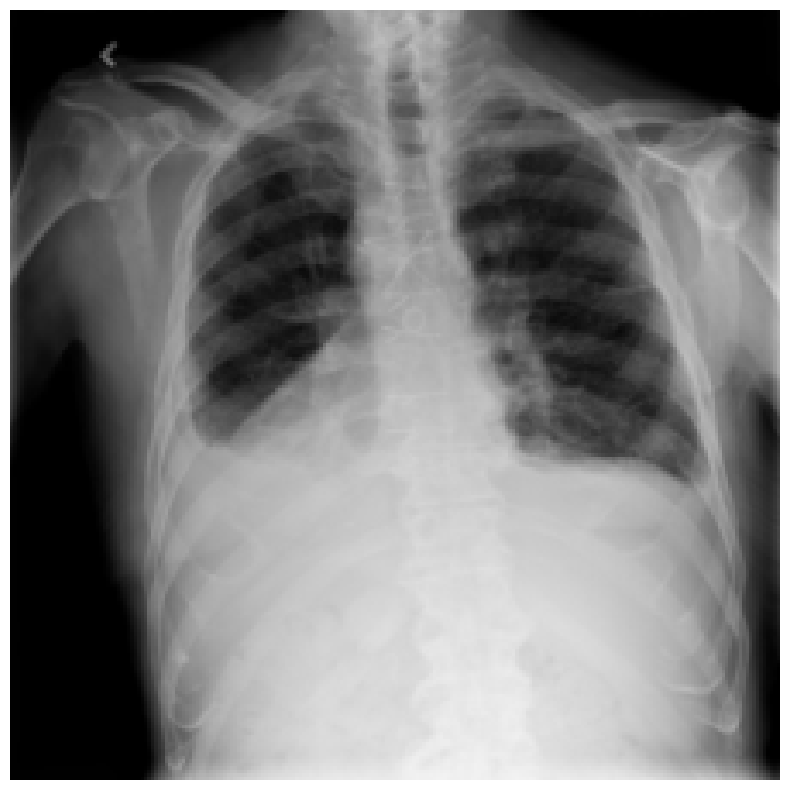

In [361]:
# Transform image
image = plt.imread(img_path)
image = transform_flip(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Random Rotation**

In [362]:
transform_rotation = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Rotate the image exact 10 degrees
    transforms.Lambda(lambda img: transforms.functional.rotate(img, angle=10)),  

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

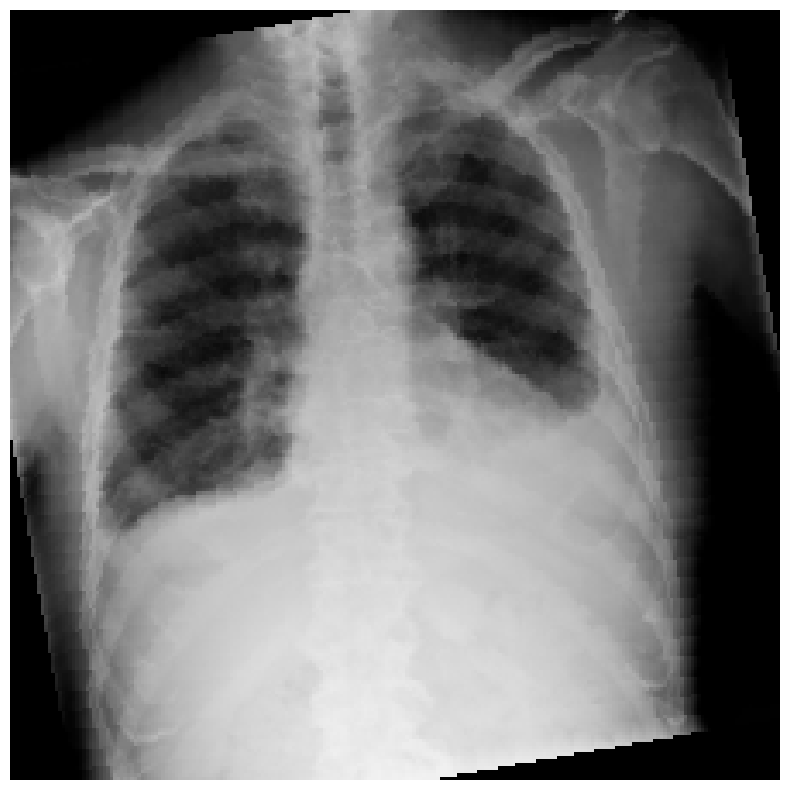

In [363]:
# Transform image
image = plt.imread(img_path)
image = transform_rotation(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Random Brightness**

In [364]:
transform_brightness = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply brightness (Exact 20 % more bright)
    transforms.Lambda(lambda img: transforms.functional.adjust_brightness(img, brightness_factor=1.2)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

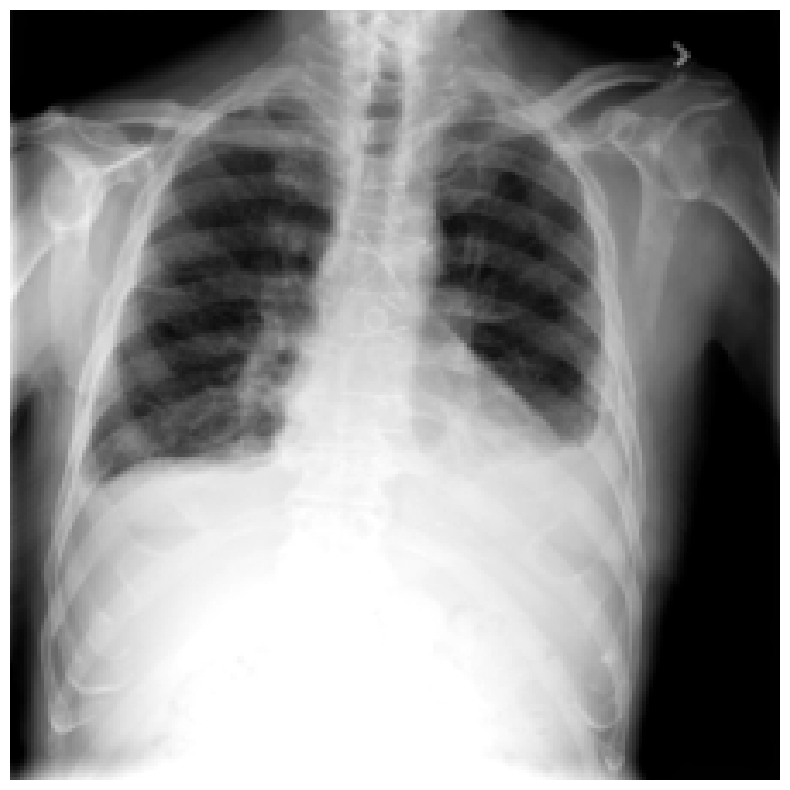

In [365]:
# Transform image
image = plt.imread(img_path)
image = transform_brightness(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Random Contrast**

In [366]:
transform_contrast = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply brightness (Exact 20 % more contrast)
    transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=1.2)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

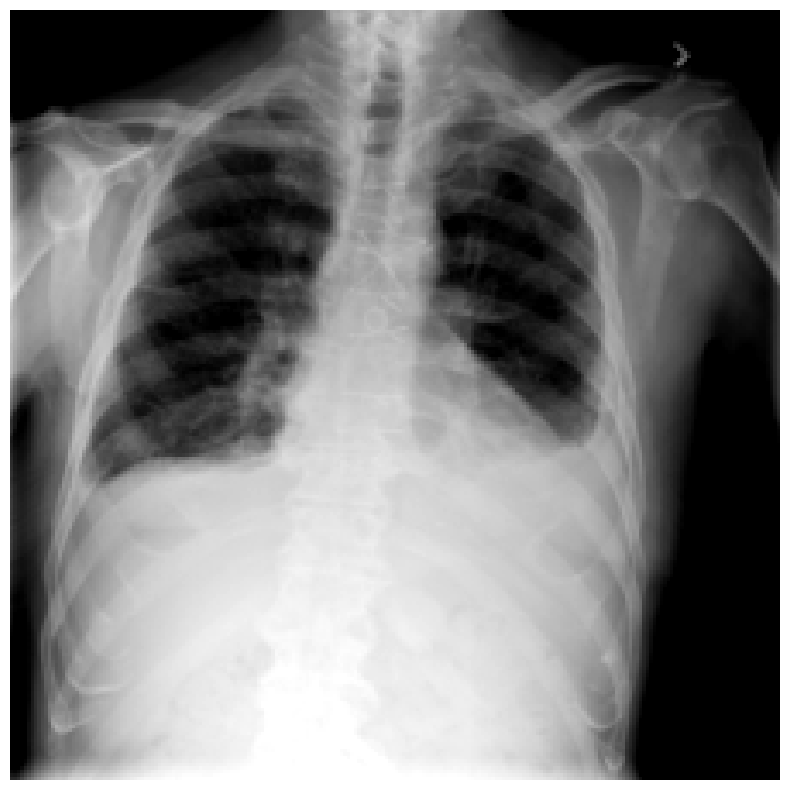

In [367]:
# Transform image
image = plt.imread(img_path)
image = transform_contrast(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Random Erasing**

In [368]:
transform_erasing = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Random erasing of image
    transforms.RandomErasing(p=1.0, scale=(0.02, 0.1))
])

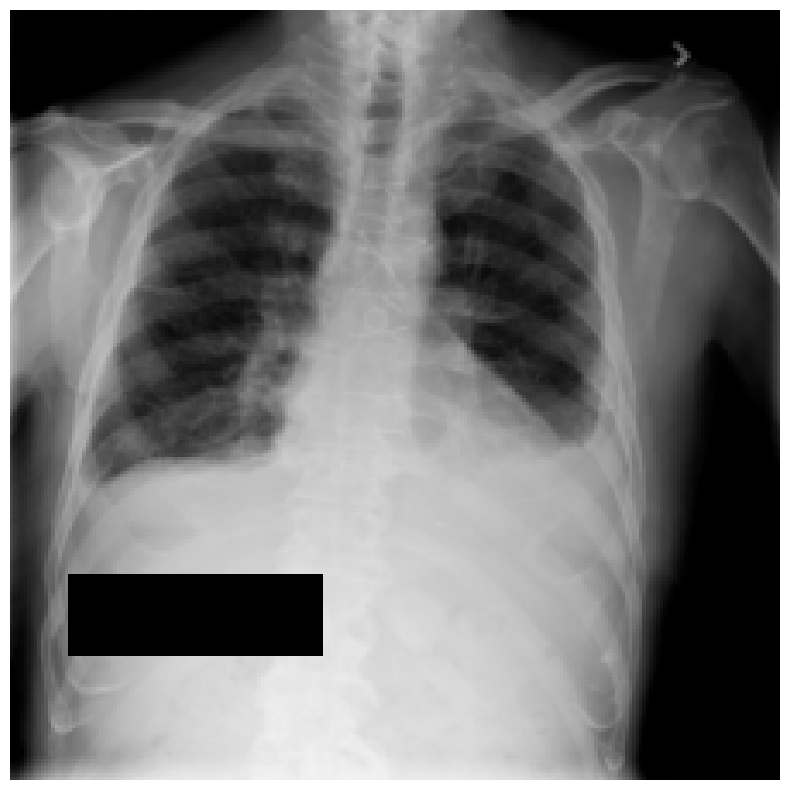

In [369]:
# Transform image
image = plt.imread(img_path)
image = transform_erasing(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Random Gaussian Blur**

In [370]:
transform_gaussian_blur = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply random gaussian blur
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.5)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

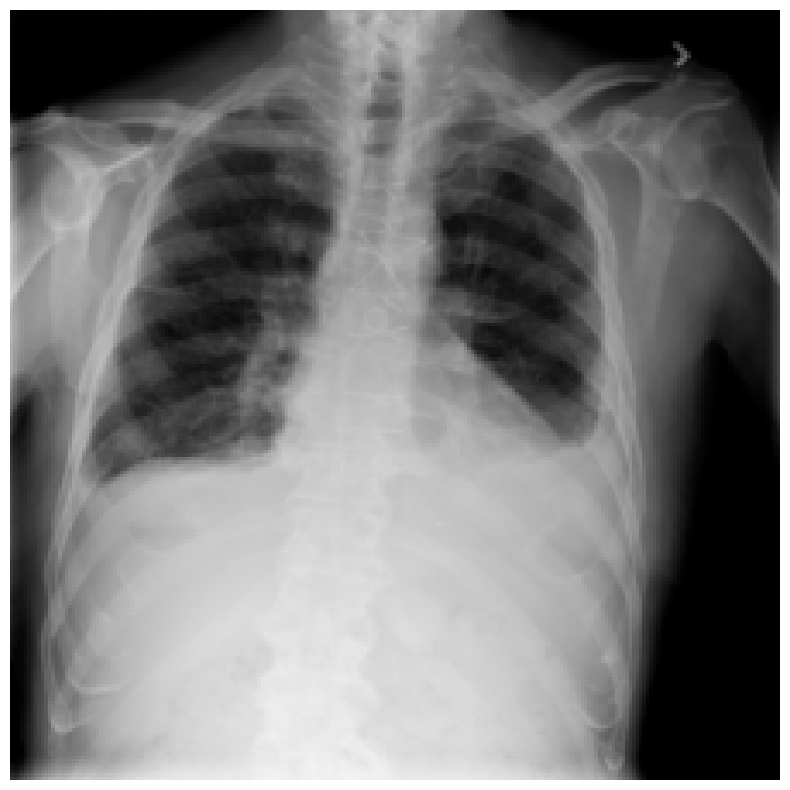

In [371]:
# Transform image
image = plt.imread(img_path)
image = transform_gaussian_blur(image)

# Plot the samples
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()